# Hello again!

This is Group 9's Jupyter Notebook for data modeling & analysis. Now that we've cleaned up and explored our data, it's time to make use of machine learning models to figure out trends in the data.

As always, we'll try to make this fun to read through. Enjoy!

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Machine Learning (LDA)

The main model we'll use is called __Latent Dirichlet Allocation (LDA)__. In our case, LDA works by assigning words to different topics then classifying tweets by those topics.

Before anything else, we need the processed dataset from data exploration. This is again hosted in one of Daryll's GitHub repositories, so we'll yoink that into this notebook:

## Describe the structure and mechanism of the chosen model

## Train the model using the training data


## Evaluate the model's performance using the appropriate evaluation metrics

## Evaluation results

In [ ]:
CSV_PATH = "https://raw.githubusercontent.com/daryll-ko/cs132-main/main/analyzer/processed_data.csv"

In [ ]:
df = pd.read_csv(CSV_PATH)

0      17/02/22 12:52
1      14/12/22 01:14
2      13/11/22 01:55
3      05/11/22 14:08
4      16/12/22 17:41
            ...      
428    11/12/21 11:26
429    10/05/22 15:52
430    18/04/22 20:42
431    21/08/21 18:08
432    11/10/21 14:15
Name: Date posted, Length: 433, dtype: object

In [ ]:
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=30)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

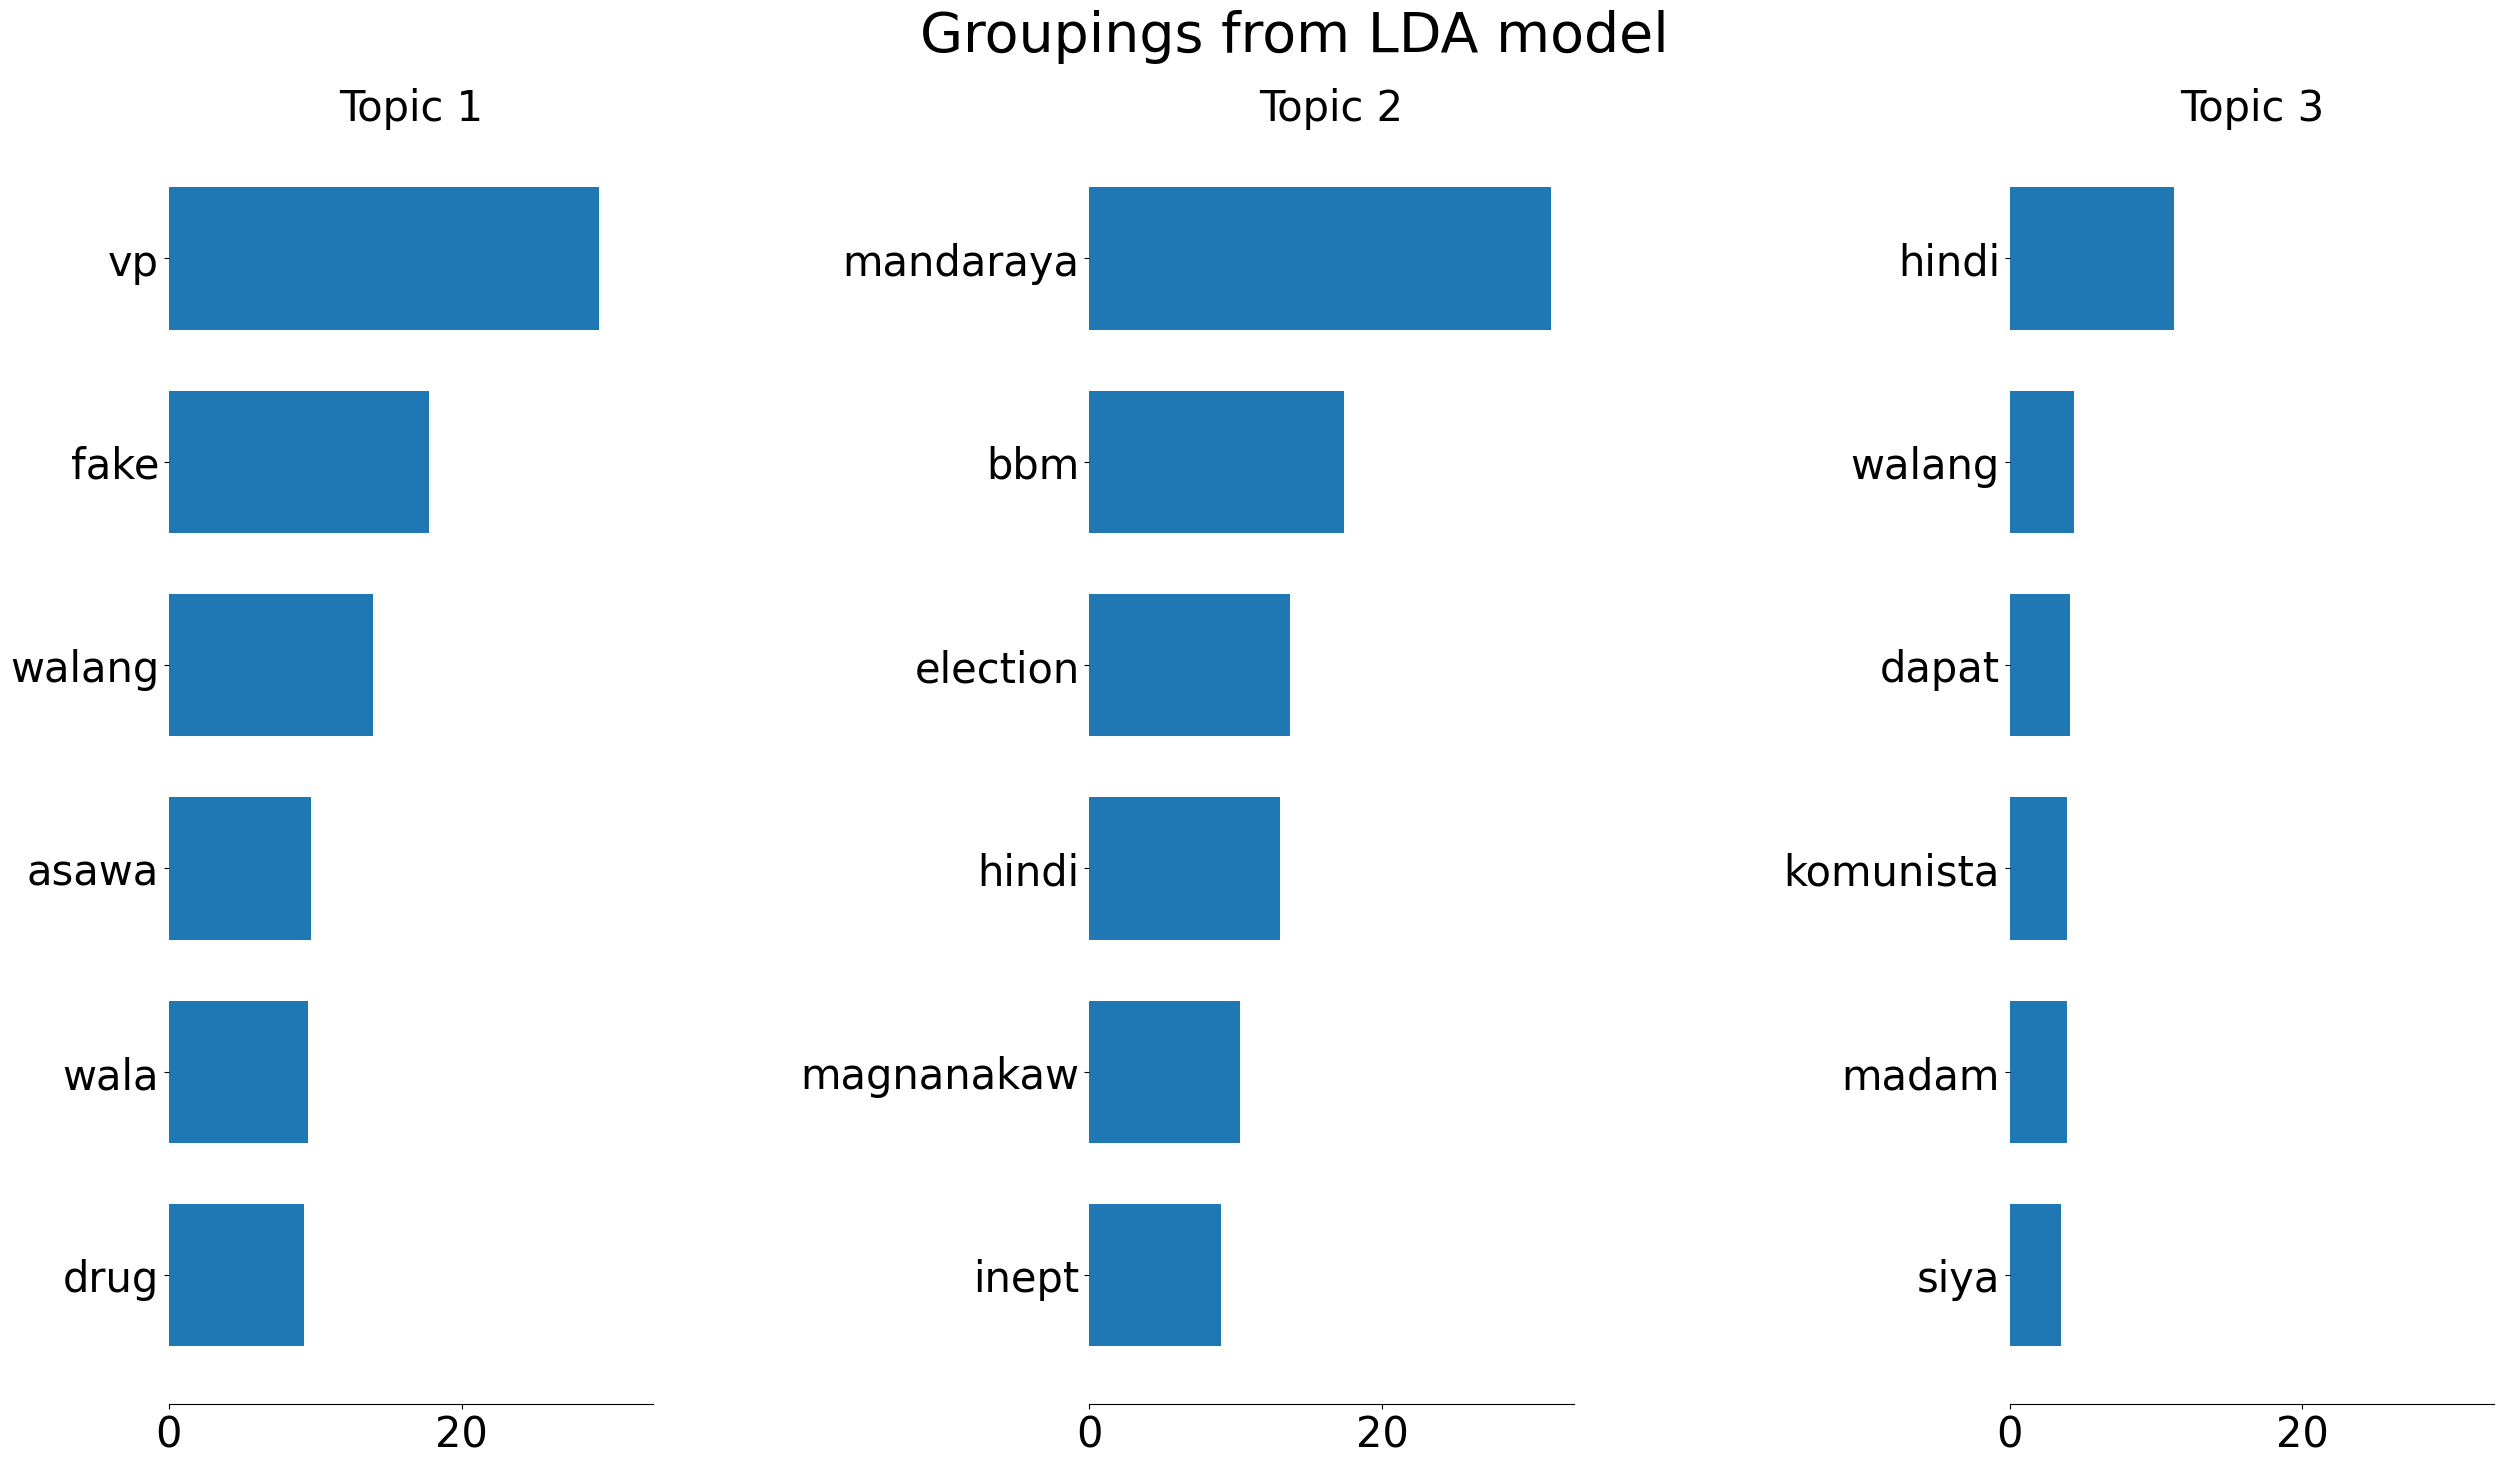

In [ ]:
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

import re

n_samples = 400
n_features = 100
n_components = 3
n_top_words = 6
batch_size = 128


final_dates = []
final_samples = []


def clean_date_unit(s):
    if len(s) == 1:
        return f"0{s}"
    elif len(s) == 4:
        return s[-2:]
    else:
        return s


def valid_month(s):
    return 1 <= int(s) <= 12


bad_date = "00-00-00"


def purify(date):
    matches = re.search(r"^(\d+)/(\d+)/(\d+) .+$", date)
    if matches:
        d, m, y = matches.groups()
        if not valid_month(m):
            d, m = m, d
        m = str((int(m) - 1) // 3 * 3 + 1)
        return f"{clean_date_unit(y)}-{clean_date_unit(m)}"
    else:
        return bad_date


data_samples = df[["Date posted", "Tweet (processed)"]][:n_samples]
for index, row in data_samples.iterrows():
    date, sample = row["Date posted"], row["Tweet (processed)"]
    if isinstance(sample, str):
        tokens = list(map(lambda token: token[1:-1], sample[1:-1].split(", ")))
        tokens = list(
            filter(lambda token: token not in ["leni", "robredo", "hahaha"], tokens)
        )
        purified_date = purify(date)
        if len(tokens) > 0 and purified_date != bad_date:
            final_dates.append(purified_date)
            final_samples.append(" ".join(tokens))

tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(final_samples)


lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(tf)


tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Groupings from LDA model")

In [ ]:
%%capture
# Initialize NLP components
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from textblob import TextBlob

%pip install pyspellchecker
from spellchecker import SpellChecker

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()

In [ ]:
%%capture
%pip install emoji --upgrade
# !pip install pyLDAvis

In [ ]:
# Topic modeling via LDA
# Source: https://www.kaggle.com/code/infamouscoder/lda-topic-modeling-features
import re
import emoji

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import decomposition

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


# Custom tokenizer
def tokenizer(text):
    text = emoji.replace_emoji(text, replace="")  # remove emojis
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # remove whitespaces
    tokens = [
        word for word in word_tokenize(text) if len(word) > 3
    ]  # keep only 4+-length words
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    filtered_tokens = [
        token for token in lemmatized_tokens if token.lower() not in stop_words
    ]
    # stemmed_tokens = [stemmer.stem(item) for item in tokens]
    return filtered_tokens


# Generate features
tf_vectorizer = TfidfVectorizer(
    tokenizer=tokenizer,
    max_df=0.75,
    max_features=10000,
    use_idf=True,
    norm=None,
    token_pattern=None,
)
tf_vectors = tf_vectorizer.fit_transform(final_samples)

n_topics = 3
lda = decomposition.LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=10,
    learning_method="online",
    learning_offset=50,
    n_jobs=1,
    random_state=42,
)
W = lda.fit_transform(tf_vectors)
H = lda.components_

num_words = 10
vocab = np.array(tf_vectorizer.get_feature_names_out())
top_words = lambda t: [vocab[i] for i in np.argsort(t)[: -num_words - 1 : -1]]
topic_words = [top_words(t) for t in H]
topics = [" ".join(t) for t in topic_words]
df_topics = pd.DataFrame(topics, columns=["Keywords"])
df_topics["Topic ID"] = range(1, len(topics) + 1)

In [ ]:
# Assign topic to each tweet
topicid = ["Topic" + str(i + 1) for i in range(lda.n_components)]
tweetid = ["Tweet" + str(i + 1) for i in range(len(final_samples))]

df_topics_lda = pd.DataFrame(np.round(W, 2), columns=topicid, index=tweetid)
significanttopic = np.argmax(df_topics_lda.values, axis=1) + 1

df_topics_lda["dominant_topic"] = significanttopic
df_topics_lda["breakdown"] = df_topics_lda.apply(
    lambda row: "\n".join(
        [
            f"{col}: {row[col]}"
            for col in sorted(df_topics_lda.columns, key=lambda x: row[x], reverse=True)
            if row[col] > 0 and col != "dominant_topic"
        ]
    ),
    axis=1,
)
df_topics_lda["date"] = pd.to_datetime(np.array(final_dates), format="%y-%m")
df_topics_lda.head(10)

,Topic1,Topic2,Topic3,dominant_topic,breakdown,date
Tweet1,0.99,0.01,0.01,1,Topic1: 0.99\nTopic2: 0.01\nTopic3: 0.01,2022-01-01
Tweet2,0.01,0.00,0.99,3,Topic3: 0.99\nTopic1: 0.01,2022-10-01
Tweet3,0.97,0.01,0.01,1,Topic1: 0.97\nTopic2: 0.01\nTopic3: 0.01,2022-10-01
Tweet4,0.00,0.99,0.00,2,Topic2: 0.99,2022-10-01
Tweet5,0.00,0.99,0.00,2,Topic2: 0.99,2022-10-01
Tweet6,0.99,0.00,0.00,1,Topic1: 0.99,2022-10-01
Tweet7,0.00,0.00,0.99,3,Topic3: 0.99,2022-10-01
Tweet8,0.00,1.00,0.00,2,Topic2: 1.0,2022-10-01
Tweet9,0.00,0.99,0.00,2,Topic2: 0.99,2022-10-01
Tweet10,0.01,0.01,0.99,3,Topic3: 0.99\nTopic1: 0.01\nTopic2: 0.01,2022-04-01


In [ ]:
# Visualize topics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly.express as px

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(df_topics_lda.iloc[:, :n_topics])

# Apply K-means clustering
n_topics = 3
kmeans = KMeans(n_clusters=n_topics, n_init=3, random_state=42)
cluster_labels = kmeans.fit_predict(df_topics_lda.iloc[:, :n_topics])

In [ ]:
# Create a new dataframe with t-SNE coordinates and cluster labels
import textwrap


def split_text(text, max_length):
    lines = textwrap.wrap(text, width=max_length, break_long_words=False)
    return "<br>".join(lines)


df_topics_cluster = pd.DataFrame(
    {
        "X": tsne_result[:, 0],
        "Y": tsne_result[:, 1],
        "Tweet": final_samples,
        "Cluster": df_topics_lda.reset_index()["dominant_topic"].astype(
            str
        ),  # topics via LDA
        # 'Cluster': cluster_labels},                                         # clusters via K-means
        "Breakdown": df_topics_lda.reset_index()["breakdown"],
    }
)

df_topics_cluster["Tweet"] = df_topics_cluster["Tweet"].apply(
    lambda x: split_text(x, 40)
)
df_topics_cluster["Breakdown"] = df_topics_cluster["Breakdown"].str.replace(
    "\n", "<br>"
)

df_topics_cluster.head(10)

,X,Y,Tweet,Cluster,Breakdown
0,-50.295345,312.728455,wala alam foreign policy alam presidente<br>au...,2,Topic2: 0.99<br>Topic1: 0.01<br>Topic3: 0.01
1,-54.662102,160.498718,walang ambag maritime industry years vp<br>nev...,2,Topic2: 0.81<br>Topic3: 0.19
2,-289.994049,-155.840195,inggit walang ambag moro chaka,3,Topic3: 0.97<br>Topic1: 0.01<br>Topic2: 0.01
3,65.030510,-32.258495,wala kasing ibang topic alam walang alam<br>ph...,1,Topic1: 0.99
4,59.901714,62.886303,vovo matagal walang galaw unilever<br>ngayon g...,1,Topic1: 0.99
5,115.222878,247.850708,engot buhay nalang ngayon flops lutang<br>wala...,2,Topic2: 0.99
6,-28.807919,-149.408569,ayan nasimulan aminin nalang kakampwets<br>inf...,3,Topic3: 0.99
7,29.889677,-289.658569,bwahaha hahahaha parallel universe<br>gobyerno...,3,Topic3: 1.0
8,49.053635,-210.305069,huwag ibase respeto credentials tao<br>kahit s...,3,Topic3: 0.99
9,-50.295345,312.728455,nasa posisyon habang pandemya nagawan<br>paraa...,2,Topic2: 0.99<br>Topic1: 0.01<br>Topic3: 0.01


In [ ]:
# Plot tweets as colored points
df_topics_cluster.sort_values(
    "Cluster", key=lambda x: pd.to_numeric(x, errors="coerce"), inplace=True
)

fig = px.scatter(
    df_topics_cluster,
    x="X",
    y="Y",
    color="Cluster",
    title="Topic Clustering using LDA and t-SNE",
    hover_name="Tweet",
    hover_data={
        "X": False,
        "Y": False,
        "Cluster": False,
        "Tweet": False,
        "Breakdown": True,
    },
)

for i, keyword in enumerate(df_topics["Keywords"]):
    fig.add_annotation(
        x=0,
        y=-0.2 * (i / 5) - 0.08,
        text="Topic %d: %s" % (i + 1, keyword.replace(" ", ", ")),
        showarrow=False,
        xref="paper",
        yref="paper",
        align="left",
        font=dict(color=fig.data[i].marker["color"]),
    )

fig.update_layout(
    height=710,
    xaxis_title="",
    yaxis_title="",
    margin=dict(b=200),
    paper_bgcolor="white",
    title=dict(font=dict(color="black")),
    legend=dict(title="Topic", font=dict(color="black")),
)
fig.show()

# Statistical Hypothesis Test (Linear Regression)

## Perform the appropriate statistical test based on the hypothesis.

## Identify and validate the assumptions of the chosen statistical model. Discuss any violations of assumptions and their potential impact on the results.

## Clearly report the test statistics, p-values, and any effect size measures.

## Interpret the results and provide a conclusion based on the hypothesis test.

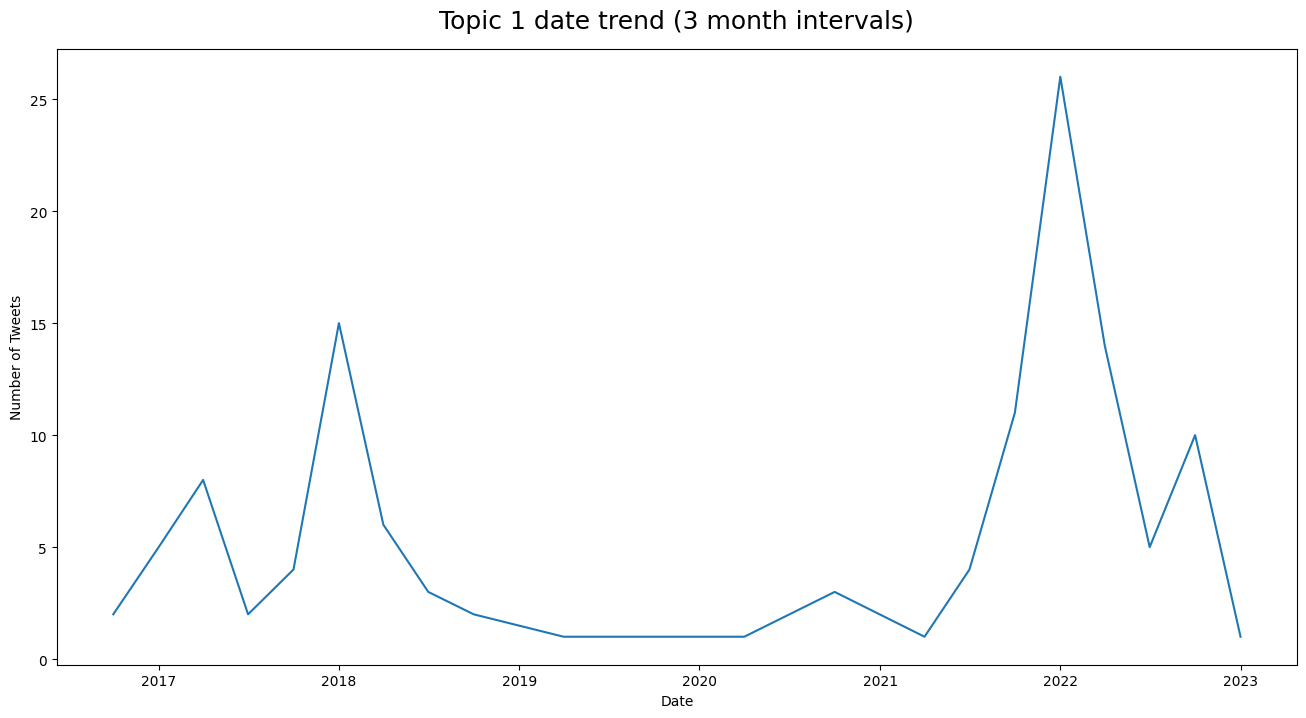

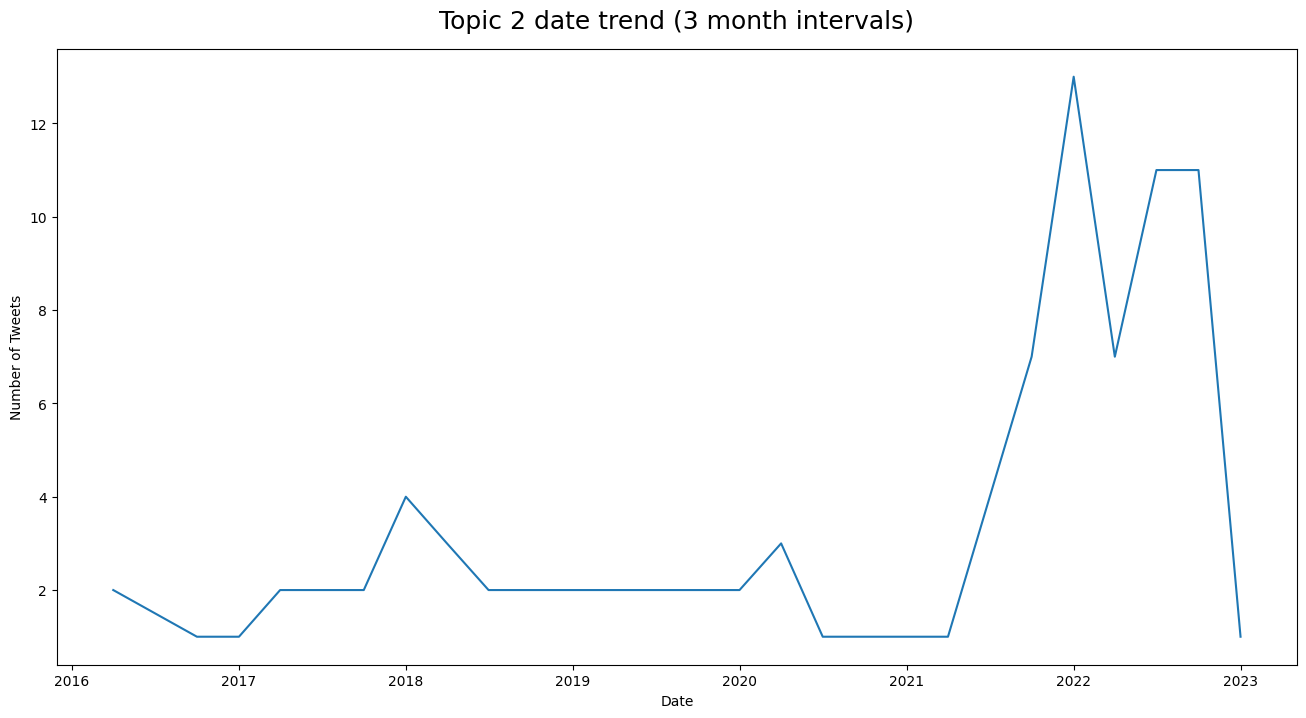

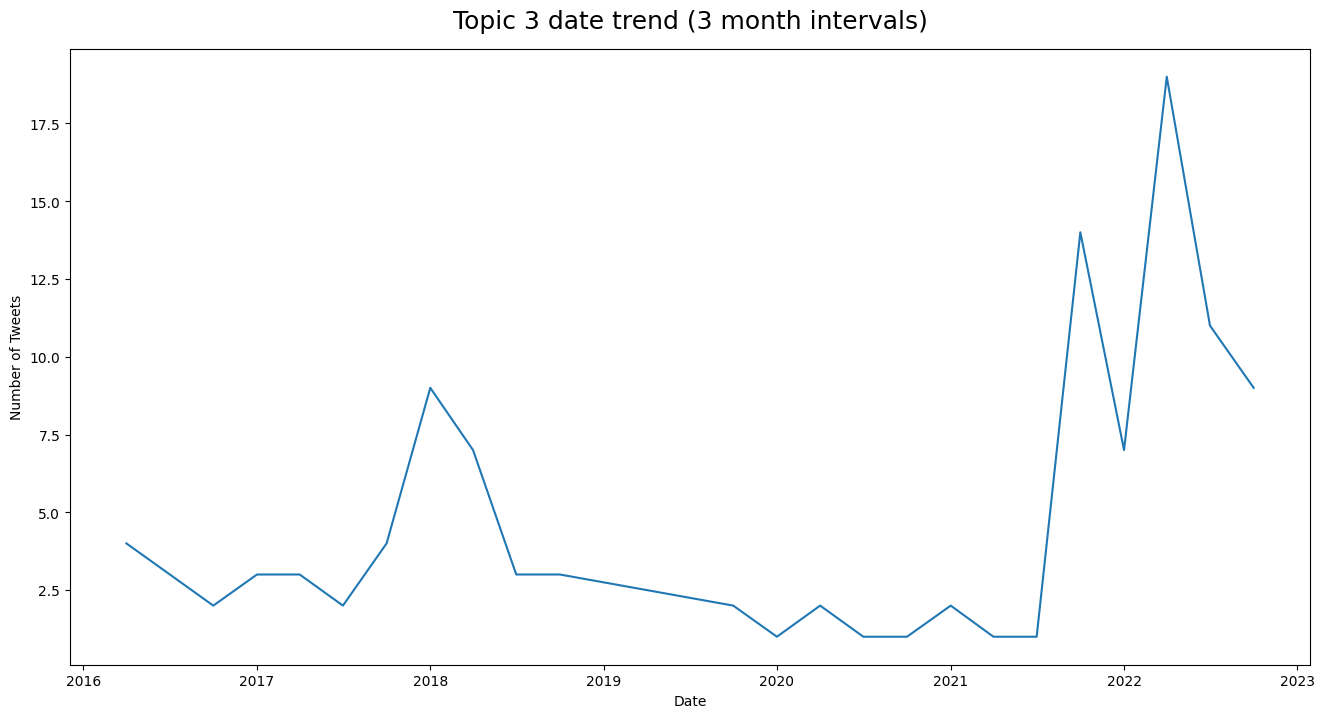

In [ ]:
for topic in range(1, 3 + 1):
    topic_df = df_topics_lda[df_topics_lda["dominant_topic"] == topic]

    date_dict = {}
    for index, row in topic_df.iterrows():
        if row["date"] in date_dict:
            date_dict[row["date"]] += 1
        else:
            date_dict[row["date"]] = 1

    date_df_dict = {"date": date_dict.keys(), "count": date_dict.values()}
    date_df = pd.DataFrame.from_dict(date_df_dict)

    plt.figure(figsize=(16, 8))
    sns.lineplot(data=date_df, x="date", y="count")

    plt.ticklabel_format(style="plain", axis="y")
    plt.xlabel("Date")
    plt.ylabel("Number of Tweets")
    plt.title(f"Topic {topic} date trend (3 month intervals)", size=18, y=1.02)

    plt.show()

In [ ]:
## Perform regression modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm


colors = ["#ee563b", "#656ffa", "#00cd96"]

for topic in range(1, 3 + 1):
    topic_df = df_topics_lda[df_topics_lda["dominant_topic"] == topic]

    date_dict = {}
    for index, row in topic_df.iterrows():
        if row["date"] in date_dict:
            date_dict[row["date"]] += 1
        else:
            date_dict[row["date"]] = 1

    date_df_dict = {"date": date_dict.keys(), "count": date_dict.values()}
    date_df = pd.DataFrame.from_dict(date_df_dict)

    # Convert datetime to int
    x = date_df["date"].astype(int) / 10**9  # Convert to seconds (UNIX epoch start)
    x = x.values.reshape(-1, 1)

    y = date_df["count"]

    # --------------------------------------------------------------
    # Linear regression model
    # --------------------------------------------------------------
    # Stastical approach
    x_lms = sm.add_constant(x)
    linear_model_stat = sm.OLS(y, x_lms)
    lms_results = linear_model_stat.fit()
    p_values = lms_results.pvalues[1:]

    # Machine learning approach (no p-values)
    linear_model = LinearRegression()
    linear_model.fit(x_lms, y)
    y_linear_pred = linear_model.predict(x_lms)

    # Calculate R2 and RMSE for linear regression model
    linear_r2 = r2_score(y, y_linear_pred)
    linear_rmse = np.sqrt(mean_squared_error(y, y_linear_pred))

    print("Model Evaluation")
    print("\nLinear Regression: RMSE=%.2f, R2=%.2f" % (linear_rmse, linear_r2))
    for i, p_value in enumerate(p_values.index):
        print(f"P({p_value}): {p_values[i]}")

    if any(p_values <= 0.05):
        print(
            "There is a significant relationship between the predictor and the response\n"
        )
    else:
        print(
            "There is no significant relationship between the predictor and the response\n"
        )

    # Plot the model
    import plotly.graph_objects as go

    xtt = date_df["date"].dt.strftime("%y-%m")
    scatter_actual = go.Scatter(
        x=xtt,
        y=y,
        mode="markers",
        name="Actual",
        marker=dict(color="blue", opacity=0.3),
    )

    line_regression = go.Scatter(
        x=xtt,
        y=y_linear_pred,
        mode="lines",
        name="LR",
        line=dict(color=colors[topic - 1], dash="dash"),
    )

    data = [scatter_actual, line_regression]

    layout = go.Layout(
        xaxis=dict(title="Date"),
        yaxis=dict(title="Tweet Count"),
        title=f"Linear Regression Model for Topic {topic}",
        showlegend=True,
        height=600,
    )

    fig = go.Figure(data=data, layout=layout)
    fig.update_xaxes(tickfont_size=20)
    fig.update_yaxes(title={"font": {"size": 20}}, tickfont_size=20)
    fig.show()

Model Evaluation

Linear Regression: RMSE=5.89, R2=0.06
P(x1): 0.25495815422448237
There is no significant relationship between the predictor and the response



Model Evaluation

Linear Regression: RMSE=3.00, R2=0.32
P(x1): 0.0070335316621953975
There is a significant relationship between the predictor and the response



Model Evaluation

Linear Regression: RMSE=4.25, R2=0.16
P(x1): 0.05845134268370579
There is no significant relationship between the predictor and the response



# Goodbye!